<a href="https://colab.research.google.com/github/RHoder/CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastai
from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.3 MB/s eta 0:00:00


Set device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Importing the zip file containing the data set

In [ ]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()

# List the uploaded files
print(uploaded.keys())


Saving state_classification_dataset.zip to state_classification_dataset.zip
dict_keys(['state_classification_dataset.zip'])


extract the zip

In [ ]:
import zipfile
import os

# Get the filename of the uploaded ZIP file (it will be in the uploaded dictionary)
zip_filename = list(uploaded.keys())[0]  # Assuming you're uploading only one file

# Define the extraction path
extract_path = "/content/images_folder"
os.makedirs(extract_path, exist_ok=True)  # Create the folder if it doesn't exist

# Extract the ZIP file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extracted files
print("Extracted files:", os.listdir(extract_path))


Extracted files: ['state_dataset']


Resizing images

In [ ]:
import zipfile
import os

zip_filename = "state_classification_dataset.zip"  # Change this to your file name
extract_path = "/content"  # Change this to the desired extraction directory

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)


Files extracted to: /content


In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(), #convert to pytorch tensor
    transforms.Normalize((0.5,), (0.5,)) #mean of .5 and standard deviation of .5
])

Loading the data set

In [ ]:
train_dataset = datasets.ImageFolder(root='/content/state_dataset/train', transform=transform) #loads training imagaes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #loads data in batches of 32 being shuffled
val_dataset = datasets.ImageFolder(root='/content/state_dataset/valid', transform=transform) #loads validiation imagaes
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True) #loads data in batches of 32 being shuffled

CNN model

In [ ]:
#currently only trained for 1 epoch, in the future to increase training efficiency we could impliment better dropout

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No activation function here (handled by CrossEntropyLoss)

        return x


Hyperparameters

In [ ]:
num_classes = len(train_dataset.classes)  # Auto-detect number of classes
learning_rate = 0.001
num_epochs = 15 #should be increased later

Initialize model

In [ ]:
model = CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training loop and plot of loss

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


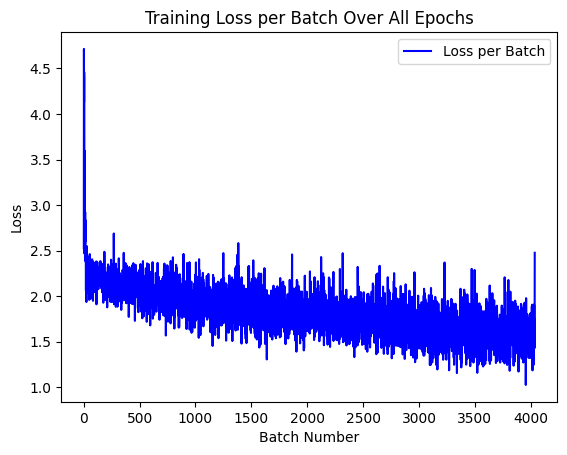

Final Loss: 2.4762


In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and batch indices across all epochs
losses = []
batch_indices = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss and batch index
        losses.append(loss.item())
        batch_indices.append(len(losses))  # Unique index across epochs



# Plotting the loss per batch after all epochs are completed
plt.plot(batch_indices, losses, label="Loss per Batch", color='blue')
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Training Loss per Batch Over All Epochs")
plt.legend()
plt.show()

print(f"Final Loss: {losses[-1]:.4f}")  # Print final batch loss


Check accuracy

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}%")

    model.train()


Run accuracy check based on unseen images

In [ ]:
check_accuracy(val_loader, model)

Got 705 / 1912 with accuracy 36.87%


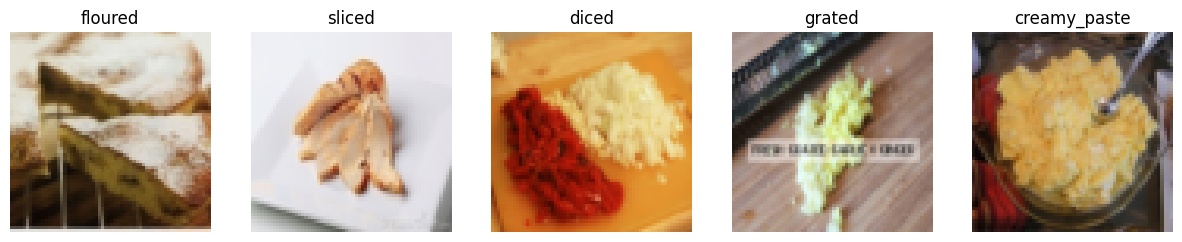

In [ ]:
import matplotlib.pyplot as plt
import random

# Function to display 5 random images from the dataset
def show_random_images(dataset, class_names, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)  # Select a random index
        img, label = dataset[idx]  # Get image and label
        img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format for displaying

        axes[i].imshow((img * 0.5) + 0.5)  # Unnormalize image
        axes[i].set_title(class_names[label])  # Set title as class name
        axes[i].axis("off")  # Hide axes

    plt.show()

# Call function
show_random_images(val_dataset, val_dataset.classes)
